# Hands-on with catalogs stored in LSD (SDSS)

### Preambule

Remember to always set the `NWORKERS`, `LSD_CACHEDIR`, and `LSD_TEMPDIR` environmental variables when using LSD on magneto. Bad things can happen otherwise (you can bring down the whole machine)!

### Creating LSD Tables and Importing Data

Let's begin with importing the usual tools -- `numpy`, `matplotlib`, etc.

In [1]:
import numpy as np

from astropy.table import Table, Column

%matplotlib inline
import matplotlib.pyplot as plt

Import what we need to run LSD queries

In [2]:
from lsd import DB
from lsd.bounds import beam, rectangle

Let's check that we've got all our environmental variable set. Note that I've added another directory to my 'LSD_DB' path -- this is a way to query catalogs from multiple LSD databases at the same time. Any new tables will be created in the first directory on the path.

In [3]:
import os

print os.environ['NWORKERS']
print os.environ['LSD_DB']
print os.environ['LSD_CACHEDIR']
print os.environ['LSD_TEMPDIR']

8
/astro/users/mjuric/lsddb:/astro/apps6/opt/lsddb
/astro/users/mjuric/tempdir
/astro/users/mjuric/tempdir


We'll import the results of the CASJobs queries into LSD, to make it easy to cross-match and examine the data. To make that easier, let's first add `ra` and `dec` columns to the files we'll be importing (remember that our CASJobs query only asked for `l` and `b`).

This block of code also demonstrates how to read and write `astropy.Table`s, convert coordinates, and add columns to existing tables.

In [4]:
from astropy.coordinates import SkyCoord, Galactic

for fn in ['field1', 'field2']:
    t = Table.read(fn + '_mjuric2.fit')

    pos = SkyCoord(frame="galactic", l=t['l'], b=t['b'], unit="deg")
    ra_col = Column(name='ra', data=pos.icrs.ra)
    dec_col = Column(name='dec', data=pos.icrs.dec)

    t.add_columns([ra_col, dec_col])
    t.rename_column('Column1', 'rErr')

    t.write(fn + '.fits', overwrite=True)

Let's see what we've got:

In [5]:
t = Table.read('field1.fits')
t[:10]

objid,l,b,Ar,g,r,gErr,rErr,flags,ra,dec
,,,,,,,,,deg,deg
int64,float64,float64,float32,float32,float32,float32,float32,int64,float64,float64
1237680502895411476,94.0156204064,-24.0597255437,0.169935,17.02,16.5866,0.00448013,0.00446085,35253360136208,341.598633445,31.6985208433
1237680502895411888,94.0194268312,-24.0557383294,0.170626,19.9807,19.1704,0.0197801,0.0136489,68988044032,341.599787439,31.7037184348
1237680502895411470,94.0150005157,-24.0556641459,0.170648,16.7239,16.2172,0.00411418,0.0041405,68987912704,341.595645043,31.7017380998
1237680502895411475,94.0158822152,-24.0645132455,0.169103,14.2485,14.7208,0.00371583,0.0109408,202312555827216,341.601721828,31.6945115695
1237680502895412374,94.0243235537,-24.0603958684,0.169571,21.8242,21.247,0.0819348,0.065981,68987912448,341.607089899,31.7019615842
1237680502895411477,94.0186942953,-24.065669768,0.168873,21.0386,20.068,0.0438189,0.0252185,175990848754448,341.605012598,31.6948124255
1237680502895411776,94.0224809055,-24.0500217391,0.171474,23.9334,22.5517,0.435131,0.194558,35259836006672,341.599217072,31.7100605043
1237680502895411785,94.0254726792,-24.0670856741,0.168352,21.1935,20.8015,0.0486659,0.0453536,35253360132368,341.612129646,31.6967205604


Let's create the table for these data. First write the YAML schema:

In [6]:
! cat sdss_sample.yaml

# Schema for SDSS table subset
filters: {complevel: 5, complib: blosc}
schema:
  common:
    primary_key: sdss_id
    spatial_keys: [ra, dec]
    columns:
    - [sdss_id, u8]
    - [objid, u8]
    - [ra, f8]
    - [dec, f8]
    - [l, f8]
    - [b, f8]
    - [Ar, f4]
    - [g, f4]
    - [r, f4]
    - [gErr, f4]
    - [rErr, f4]
    - [flags, u8]


Now create the table:

In [7]:
# Run this to get rid of any existing tables
! chmod -R +w ~/lsddb/sdss_sample; rm -rf ~/lsddb/sdss_sample

chmod: cannot access `/astro/users/mjuric/lsddb/sdss_sample': No such file or directory


Create the table:

In [8]:
! lsd-admin create table --schema sdss_sample.yaml sdss_sample


-------- committing 20160209185246.615890 [sdss_sample] ---------
[sdss_sample] Updating tablet catalog: [256 el.]::::::::::::::::::::>  0.26 sec
[sdss_sample] Updating neighbors: Already up to date.
[sdss_sample] Updating tablet catalog: [256 el.]::::::::::::::::::::>  0.26 sec
[sdss_sample] Updating stats: [0 el.]>  0.00 sec
[sdss_sample] Marking tablets read-only...
----------- success 20160209185246.615890 [sdss_sample] ---------

Table 'sdss_sample' created.


Import the data (both fields):

In [9]:
! lsd-import fits sdss_sample field1.fits field2.fits

Importing from 2 pieces:
  ===> Imported field1.fits                                                            [1/2, 50.00%] +  76562/76562       76562 (0/0 min.)
  ===> Imported field2.fits                                                            [2/2, 100.00%] +  62899/62899      139461 (0/0 min.)
done

-------- committing 20160209185332.210819 [sdss_sample] ---------
[sdss_sample] Updating tablet catalog: [256 el.]::::::::::::::::::::>  0.25 sec
[sdss_sample] Updating neighbors: [6 el.]::::::::::::::::::::[28 el.]++++++++++++++++++++>  1.41 sec
              Total 15784 cached objects in 28 cells
[sdss_sample] Updating tablet catalog: [256 el.]::::::::::::::::::::>  0.28 sec
[sdss_sample] Updating stats: [28 el.]::::::::::::::::::::>  0.04 sec [28 el.]::::::::::::::::::::>  0.09 sec
[sdss_sample] Marking tablets read-only...
----------- success 20160209185332.210819 [sdss_sample] ---------



In [10]:
# We could've also explicitly chosen which columns to import:
# ! lsd-import fits --cols objid,ra,dec,l,b,Ar,g,r,gErr,rErr,flags sdss_sample field1.fits field2.fits

"Connect" to our database:

In [11]:
db = DB(os.environ['LSD_DB'])

Let's do the queries:

In [15]:
bounds = [ (beam(341.6, 31.7, 1), None) ]   # Note that the radius is in degrees!

In [18]:
data_casjobs = db.query('select l, b from sdss_sample').fetch(bounds=bounds)

 [2 el.]::::::::::::::::::::>  0.06 sec


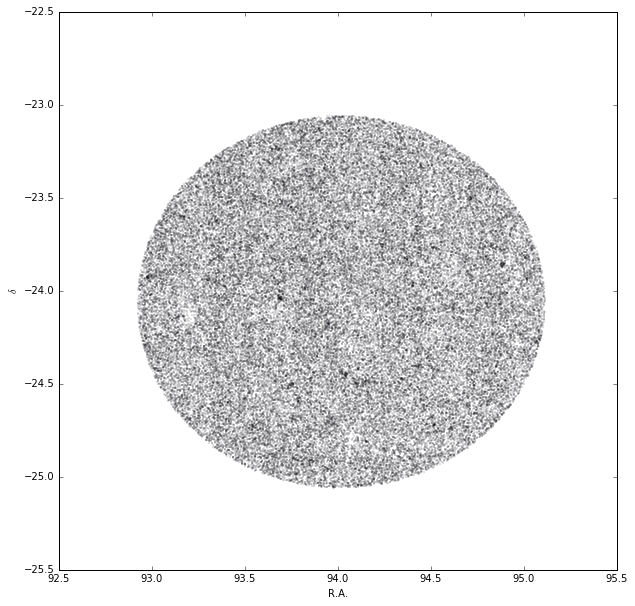

In [19]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(data_casjobs.l, data_casjobs.b, marker='.', s=0.1)

ax.set_xlabel("R.A.")
ax.set_ylabel("$\delta$")

 [2 el.]::::::::::::::::::::>  0.23 sec


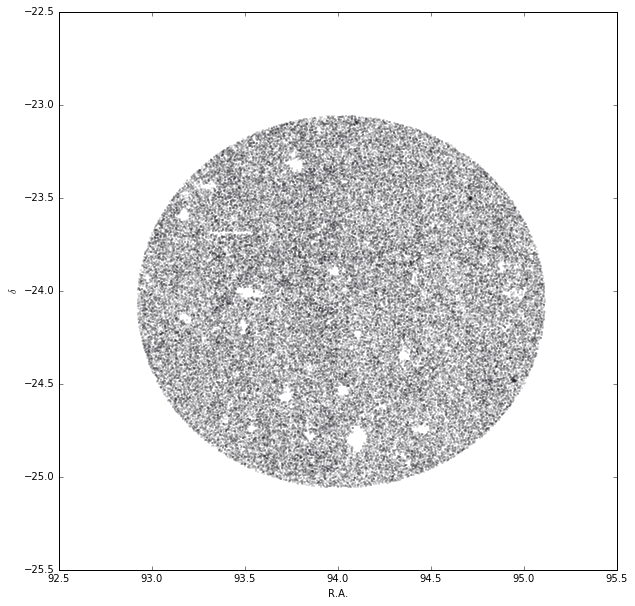

In [20]:
data_lsd = db.query('select l, b from sdss').fetch(bounds=bounds)

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(data_lsd.l, data_lsd.b, marker='.', s=0.1)

ax.set_xlabel("R.A.")
ax.set_ylabel("$\delta$")

Now, let's cross-match. Query for all objects in the CASJobs result that don't have a counterpart (within 1") in LSD:

 [2 el.]::::::::::::::::::::>  0.57 sec


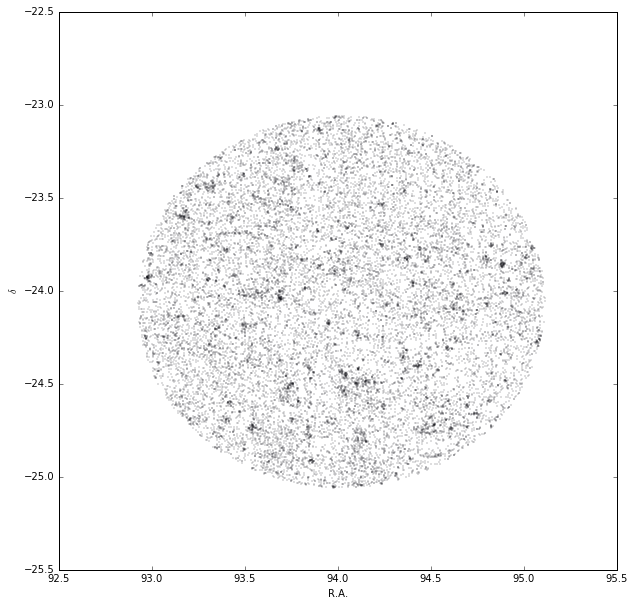

In [28]:
not_in_lsd = db.query(
"""SELECT l, b, r, rErr, run, flags, sdss._ISNULL
FROM sdss_sample, sdss(matchedto=sdss_sample, outer)
WHERE sdss._ISNULL == True""").fetch(bounds=bounds)

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(not_in_lsd.l, not_in_lsd.b, marker='.', s=0.1)

ax.set_xlabel("R.A.")
ax.set_ylabel("$\delta$")